# Pre Processing: Feature Selection

Feature Selection is an important step in data pre-processing. It consists in selecting the best subset of input variable as the most pertinent. Discarding irrelevant data is essential before applying Machine Learning algorithm in order to:
* *Reduce Overfitting*: less opportunity to make decisions based on noise;
* *Improve Accuracy*: less misleading data means modelling accuracy improves. Predictions can be greatly distorted by redundant attributes. 
* *Reduce Training Time*: With less data the algorithms will train faster;


### Import Libraries

In [ ]:
from tokenize import String

import scipy.stats as stats
import geopandas as gpd
import numpy as np
from numpy import arange
from fs import methods as m
from fs import model as ml
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, clear_output
from sklearn import preprocessing
import os
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import AppLayout, Layout

pd.set_option('display.max_rows', 500)


### Dataframe 

In [ ]:
RESOLUTION= '0_1'
KNN = True
knn_value = 10
NO_MOUNTAINS = True
geopackages = os.listdir('assets/grids_'+RESOLUTION)
grid_data = []
dataframes_results = {}
var_t = 'empty'
target_labels = []
target_labels.append('pm25_cams')





## Results Feature Selection
In this section fs results are evaluated for each geopackages contained in the folder [grids/](https://github.com/opengeolab/D-DUST/tree/thesis_MB/notebooks/grids).<br />
The results are stored in a list of dataframe (one for each dataset) and are displayed in n bar plot. <br />
Each subplot refers to the method choosen with the dropdown widgets, with the possiblity to normalized results or not. <br />
The methods used are:

* Pearson correlation;
* Spearmanr correlation;
* Kendall tau; 
* F-Test;
* Random Forest importance; 

<br />
In addition, an average score for these methods is added.



In [ ]:
labels = list(gpd.read_file('assets/grids_'+RESOLUTION+'/'+ geopackages[0]).dropna(axis=0).dropna(axis=1).columns)
frequencies_tables = []
method_list = ['Pearson', 'Spearmanr', 'Kendall', 'Fisher', 'RF Importance', 'RFS']
for l in labels:
    if(l.endswith('_st')):
        target_labels.append(l)

results_norm = widgets.Checkbox(
    value=True,
    description='Results normalized',
    disabled=False,
    indent=True
)

#Radiobutton used to display data in regular or logaritmic scale
scale = widgets.RadioButtons(
    options=['Regular', 'Logaritmic'],
    description='Scale:',
    disabled=False
)

compute_button = widgets.Button(
    description='Compute',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='Compute',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width='60%', margin='10px 150px 10px 80px')


)

#Radiobutton used to display data ordered by score or by labels
order = widgets.RadioButtons(
    options=['Labels', 'Scores'],
    description='Order by:',
    disabled=False
)
#Dropdown widgets used to choose the scores of the method selected
method_choosen = widgets.Dropdown(
    options=['---']+ method_list + ['Borda Count Voting', 'Final Score'],
    value='---',
    description='Method:',
    disabled=False,
    layout = Layout(width='90%')
)




target_variable = widgets.Dropdown(
    options=target_labels,
    value=target_labels[0],
    description='Target:',
    layout = Layout(width='90%')
)

variance_TH= widgets.Checkbox(
    value=True,
    description='Apply',
    disabled=False,
    indent=False,
    layout = Layout(margin='10px 10px 10px 80px')

)

value_th = widgets.Dropdown(
    options=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    value=0,
    description='Variance TH:',
    disabled=False,
    layout = Layout(width='90%')

)

labels_list = []
def compute_button_f(b):
    clear_output()
    global features_deleted
    global th
    global frequencies_tables

    global var_t
    global labels
    global dataframes_results
    global grid_data

    labels_list.clear()
    dataframes_results.clear()

    var_t = target_variable.value
    grid_data = []
    to_print = '<h3>Features deleted</h3>'

    for index, grid in enumerate(geopackages):
        #read gpkg file
        data = gpd.read_file('assets/grids_'+RESOLUTION+'/'+ grid)
        if KNN:
            data = m.process_data(data, knn_value, target_variable.value, NO_MOUNTAINS)
    
        data = data[~data[target_variable.value].isnull()]
        data = data.dropna(axis=1).dropna(axis=0)
        data.pop('geometry')

        grid_data.append(data)

        labels = list(data.columns)

        #read variables which are not null
        score_results = pd.DataFrame()

        #Store dataset in x and y variables
        X = pd.DataFrame(data=data, columns=labels )
        Y = X[target_variable.value]
        Y = Y.values.ravel()
        X.pop(target_variable.value)
        X.pop('lat_cen')
        X.pop('lng_cen')

        if value_th.disabled == False:
            scores_th = m.variance_threshold(X, value_th.value)
            to_print = to_print + '<ul>' + geopackages[index] + '</ul>'

            for i, label in enumerate(scores_th['Features']):
                if scores_th['Scores'].tolist()[i] != 1:
                    to_print = to_print + '<li>' + label + '</li>'
                    X = X.drop(label, 1)
        else:
            to_print = to_print + 'None'
            
        features_deleted = widgets.HTML(to_print)

        X = X.apply(stats.zscore)
        X = X.dropna(axis=1)
        Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
        
        labels = X.columns.tolist()
        labels_list.append(labels)
        score_results['Features'] = labels

        score_results = m.fs_results_computation(X, Y)
        frequency = pd.DataFrame()

        frequency['Features'] = labels

        for i in method_list:
            frequency[i] = score_results['Features'].isin(list(score_results.nlargest(30,i)['Features'])).astype(int)
        frequency['Final Score'] = frequency.sum(axis=1)
        
        frequencies_tables.append(frequency)
    
        s = score_results.copy()
        s['Pearson'] = s['Pearson'].abs()
        s['Kendall'] = s['Kendall'].abs()
        s['Spearmanr'] = s['Spearmanr'].abs()

        
        var_t = target_variable.value
        score_results['Final Score']=frequency['Final Score']
        score_results['Borda Count Voting'] = m.borda_voting(s)

        dataframes_results[grid] = score_results
        method_choosen.value = '---'






def fs_manager(change_scale, method, normalized_results, target, order, filter_variance, th_value):

    if filter_variance == True:
        value_th.disabled = False
    else :
        value_th.disabled = True

    if method == '---':
        return
    res = []

    if(normalized_results):
        for grid in geopackages:
            temp = (dataframes_results[grid])[method]
            temp = m.NormalizeData1D(temp)
            res.append(temp)
    else:
        for grid in geopackages:
            temp = (dataframes_results[grid])[method]
            res.append(temp)



    if (change_scale == 'Logaritmic'):
        m.show_bars_log(labels_list, res, method, geopackages, order)
        return

    else:
        m.show_bars(labels_list, res, method, geopackages, order)

title= widgets.HTML('<h2 style="text-align:center;">Options</h2><hr><h3 style="padding: 10px;">Input</h3>')
features_deleted = widgets.HTML('')
title2 = widgets.HTML('<h2 style="text-align:center;">Feature Selection scores</h2><hr>')
plots = widgets.interactive_output(fs_manager, {'method':method_choosen, 'change_scale': scale, 'order':order, 'normalized_results': results_norm, 'target': target_variable, 'filter_variance':variance_TH,'th_value':value_th })
plot = widgets.VBox([title2, plots], layout=Layout(border='solid'))
output = widgets.VBox([title, target_variable, value_th, variance_TH, compute_button, features_deleted,widgets.HTML('<br><h3 style="padding: 10px;">Output</h3'),
                           method_choosen, scale, order, results_norm], layout=Layout(border='solid'))

ui = AppLayout(header=None,
          left_sidebar=output,
          center=plot,
          right_sidebar=None,
          footer=None,
              layout=Layout(border='solid'))

compute_button.on_click(compute_button_f)

container = widgets.Box([ui], )
display(container)

Box(children=(AppLayout(children=(VBox(children=(HTML(value='<h2 style="text-align:center;">Options</h2><hr><h…

### Export Feature Selection
By running this section, a dataframe containing the list of feature selected ordered by its average score value is exported as .csv file.

grid_0_1_0418_0425_2021.gpkg


,Features,Pearson,Spearmanr,Kendall,Fisher,RF Importance,RFS,Final Score,Borda Count Voting
0,area,0.268011,0.189813,0.153367,8.191937,0.010573,11,6,89
1,pop,0.118314,0.122134,0.071997,1.931473,0.004136,10,6,50
2,int_sec,0.079307,0.043671,0.039297,2.044247,0.007389,2,6,44
3,sec_road,0.026307,-0.026228,-0.011252,0.922084,0.002702,3,6,25
4,farm_sheep,-0.087498,-0.082752,-0.060606,0.113246,0.014813,4,6,31
5,ndvi,-0.197031,-0.243238,-0.167186,2.485416,0.005602,5,6,23
6,temp_2m,0.180851,0.278783,0.175147,3.633551,0.055189,6,6,86
7,press,-0.014281,-0.025627,0.027345,0.072033,0.084755,7,6,48
8,aod_047,0.298990,0.343403,0.205607,10.298980,0.060669,8,6,112
9,nh3_cams,0.317662,0.285918,0.197646,5.772917,0.017193,9,6,101




grid_0_1_0903_0910_2021.gpkg


,Features,Pearson,Spearmanr,Kendall,Fisher,RF Importance,RFS,Final Score,Borda Count Voting
0,area,0.079484,0.165987,0.138694,0.009145,0.036263,11,6,94
1,pop,-0.142949,-0.320169,-0.208848,1.490804,0.003320,23,6,54
2,int_sec,-0.275823,-0.276582,-0.197147,7.903506,0.003454,22,6,62
3,sec_road,-0.203311,-0.249627,-0.174563,6.482863,0.003285,21,6,60
4,farm_sheep,-0.344063,-0.394105,-0.290840,15.343590,0.016637,2,6,51
5,ndvi,0.011892,0.019403,0.018764,0.234560,0.005455,3,6,55
6,temp_2m,0.395856,0.444275,0.282990,19.820055,0.022472,4,6,131
7,press,0.211293,0.180557,0.147216,5.015619,0.009440,5,6,107
8,aod_055,0.271454,0.236392,0.134706,7.682173,0.121794,6,6,130
9,aod_047,0.251139,0.208325,0.119756,7.417394,0.094214,7,6,126




grid_0_1_1007_1014_2021.gpkg


,Features,Pearson,Spearmanr,Kendall,Fisher,RF Importance,RFS,Final Score,Borda Count Voting
0,area,0.289237,0.229110,0.177162,12.229031,0.013078,29,6,148
1,pop,-0.007770,-0.180578,-0.117932,0.053334,0.022610,28,6,77
2,int_sec,-0.089951,-0.143648,-0.089430,0.337026,0.019999,6,6,63
3,sec_road,-0.052282,-0.151520,-0.097439,0.009111,0.010983,5,6,45
4,farm_sheep,-0.291228,-0.327779,-0.223539,6.040442,0.025819,1,6,54
5,ndvi,0.060919,0.009337,-0.024187,0.000069,0.009419,7,6,63
6,temp_2m,-0.024639,-0.149580,-0.064887,0.246224,0.007539,8,6,59
7,press,-0.034775,-0.092271,-0.042202,0.044270,0.055494,4,6,67
8,aod_055,0.293322,0.266055,0.168641,8.138869,0.004831,3,6,110
9,aod_047,0.259050,0.235065,0.150626,7.928256,0.004401,20,6,118




grid_0_1_0717_0724_2021.gpkg


,Features,Pearson,Spearmanr,Kendall,Fisher,RF Importance,RFS,Final Score,Borda Count Voting
0,area,0.165923,0.070784,0.045698,1.692487,0.042279,1,6,77
1,pop,0.100193,-0.062086,-0.034268,1.637281,0.003355,9,6,52
2,int_sec,-0.074632,-0.112313,-0.081537,0.046473,0.005896,20,6,42
3,sec_road,-0.004872,-0.091506,-0.065611,0.514913,0.003677,10,6,39
4,farm_sheep,-0.250768,-0.290079,-0.209178,9.070473,0.021559,2,6,48
5,ndvi,0.138472,0.184153,0.114573,0.903866,0.007471,3,6,71
6,temp_2m,0.236944,0.268380,0.169955,5.535614,0.066688,4,6,116
7,press,-0.002195,0.004125,0.014192,0.351811,0.036430,5,6,62
8,aod_055,0.188770,0.150371,0.096919,0.034945,0.013767,6,6,69
9,aod_047,0.160894,0.120838,0.077189,0.029696,0.019336,7,6,68




grid_0_1_0324_0331_2021.gpkg


,Features,Pearson,Spearmanr,Kendall,Fisher,RF Importance,RFS,Final Score,Borda Count Voting
0,area,0.167887,0.093382,0.068548,3.099750,0.006075,27,6,86
1,pop,-0.076534,0.051902,0.032883,0.326093,0.002612,26,6,58
2,int_sec,0.087655,0.113160,0.081883,1.406432,0.010882,25,6,87
3,sec_road,-0.045771,-0.000438,-0.003982,0.000157,0.002826,24,6,54
4,farm_sheep,0.236586,0.341463,0.234805,10.307905,0.003746,23,6,98
5,ndvi,0.293647,0.303476,0.205607,12.570104,0.003011,22,6,92
6,temp_2m,-0.029501,0.056942,0.046037,1.426983,0.010682,2,6,56
7,press,-0.010957,-0.039431,-0.016269,0.003154,0.003116,3,6,36
8,aod_055,0.466970,0.426591,0.289373,16.669267,0.014966,4,6,105
9,aod_047,0.474999,0.433460,0.295258,16.800369,0.004774,5,6,101




grid_0_1_0418_0425_2021.gpkg
        Features  Borda Count Voting
0       pm10_int                 146
1       no2_cams                 131
2       temp_int                 126
3    nmvocs_cams                 118
4        no2_int                 117
5        aod_047                 112
6      pm25_cams                 103
7       nh3_cams                 101
8        nox_int                  99
9         o3_int                  99
10       co_cams                  98
11          area                  89
13       temp_2m                  86
12     pm10_cams                  86
14       no_cams                  82
15       o3_cams                  67
16       nh3_int                  62
17  rad_glob_int                  61
18   air_hum_int                  60
19           pop                  50
20         press                  48
21       int_sec                  44
22      so2_cams                  42
23    farm_sheep                  31
24      sec_road                  25
25     

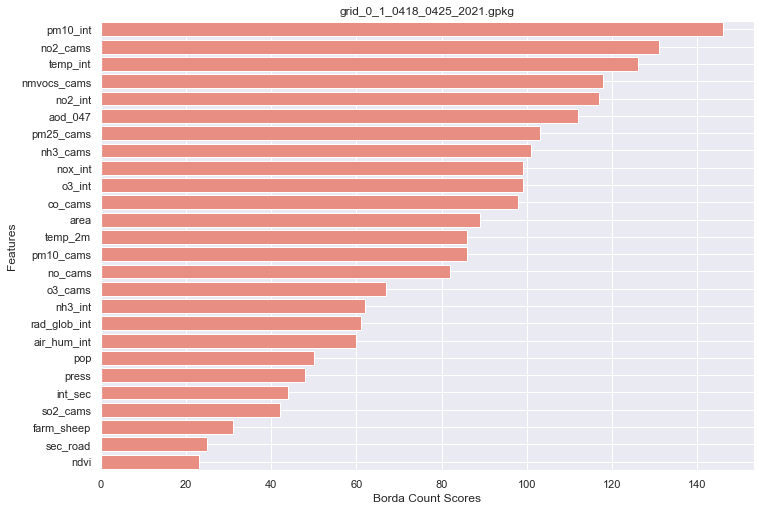

grid_0_1_0903_0910_2021.gpkg
        Features  Borda Count Voting
0        temp_2m                 131
1        aod_055                 130
2        aod_047                 126
3       pm10_int                 123
4      pm25_cams                 115
5    air_hum_int                 108
6        no2_int                 108
7          press                 107
8        nox_int                 104
9        o3_cams                  95
10          area                  94
11     pm10_cams                  88
12      so2_cams                  84
13       co_cams                  78
14       so2_int                  76
15  rad_glob_int                  76
16        o3_int                  72
17      nh3_cams                  62
18       int_sec                  62
19      sec_road                  60
20   nmvocs_cams                  58
21          ndvi                  55
22           pop                  54
23       nh3_int                  52
24    farm_sheep                  51
25      n

<Figure size 842.4x595.44 with 0 Axes>

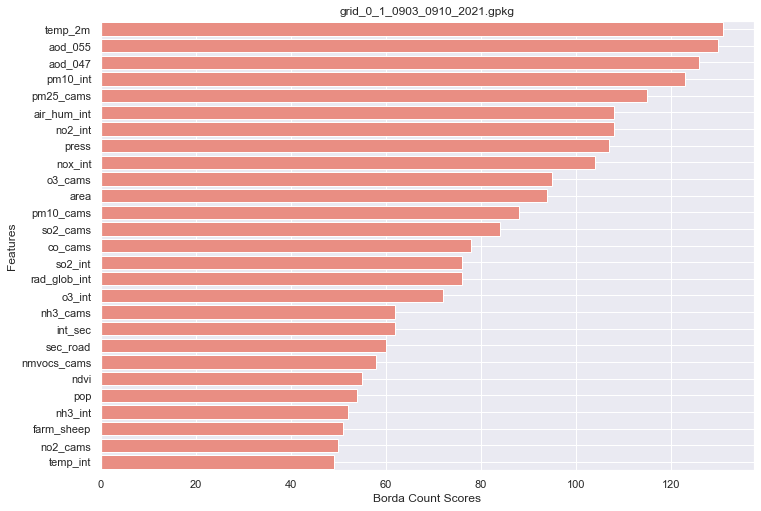

grid_0_1_1007_1014_2021.gpkg
          Features  Borda Count Voting
0     rad_glob_int                 161
1         pm10_int                 153
2             area                 148
3      nmvocs_cams                 129
4          aod_047                 118
5          no2_int                 118
6        pm25_cams                 116
7          aod_055                 110
8          nox_int                 104
9          co_cams                 100
10        so2_cams                  98
11        no2_cams                  93
12         so2_int                  92
13  wind_speed_int                  91
14         no_cams                  90
15     air_hum_int                  89
16             pop                  77
17          o3_int                  75
18        nh3_cams                  69
19       pm10_cams                  69
20           press                  67
21         o3_cams                  65
22            ndvi                  63
23         int_sec                 

<Figure size 842.4x595.44 with 0 Axes>

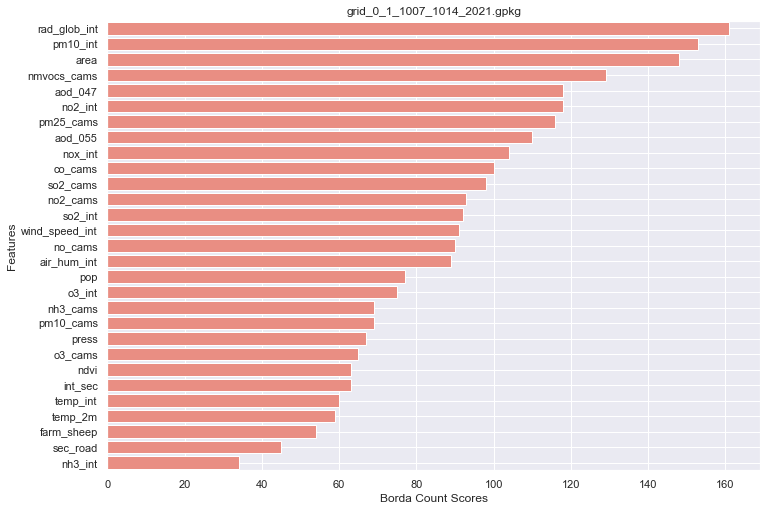

grid_0_1_0717_0724_2021.gpkg
        Features  Borda Count Voting
0   rad_glob_int                 152
1        nox_int                 150
2      pm25_cams                 141
3        no2_int                 118
4        temp_2m                 116
5    air_hum_int                 110
6    nmvocs_cams                 107
7        co_cams                 106
8       so2_cams                 100
9       no2_cams                  96
10     pm10_cams                  80
11      temp_int                  80
12          area                  77
13      nh3_cams                  74
14          ndvi                  71
15       nh3_int                  70
16       aod_055                  69
17       aod_047                  68
18      pm10_int                  67
19        o3_int                  64
20         press                  62
21       so2_int                  61
22           pop                  52
23       o3_cams                  48
24    farm_sheep                  48
25       

<Figure size 842.4x595.44 with 0 Axes>

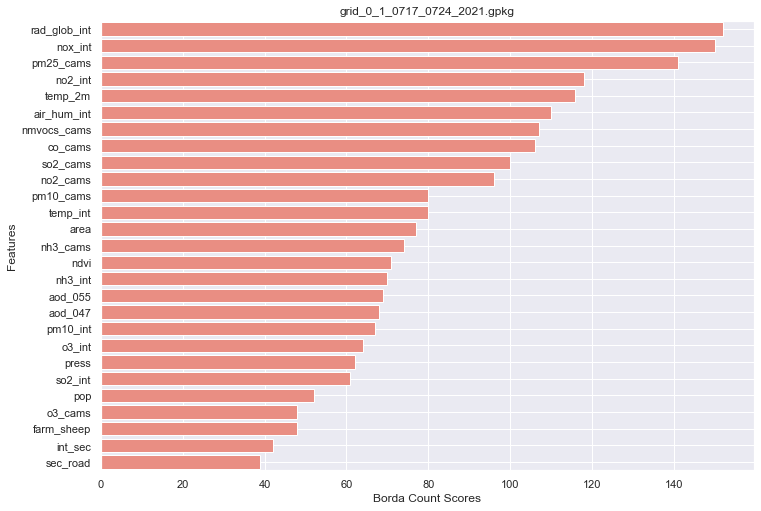

grid_0_1_0324_0331_2021.gpkg
        Features  Borda Count Voting
0       pm10_int                 154
1        nh3_int                 154
2      pm10_cams                 153
3       nh3_cams                 132
4        nox_int                 131
5      pm25_cams                 125
6        no2_int                 113
7        aod_055                 105
8        aod_047                 101
9        co_cams                 100
10    farm_sheep                  98
11          ndvi                  92
12       int_sec                  87
13          area                  86
15      temp_int                  77
14  rad_glob_int                  77
16      no2_cams                  70
17   nmvocs_cams                  66
18        o3_int                  66
19       so2_int                  62
20           pop                  58
21       temp_2m                  56
22      so2_cams                  55
23      sec_road                  54
24       no_cams                  44
25       

<Figure size 842.4x595.44 with 0 Axes>

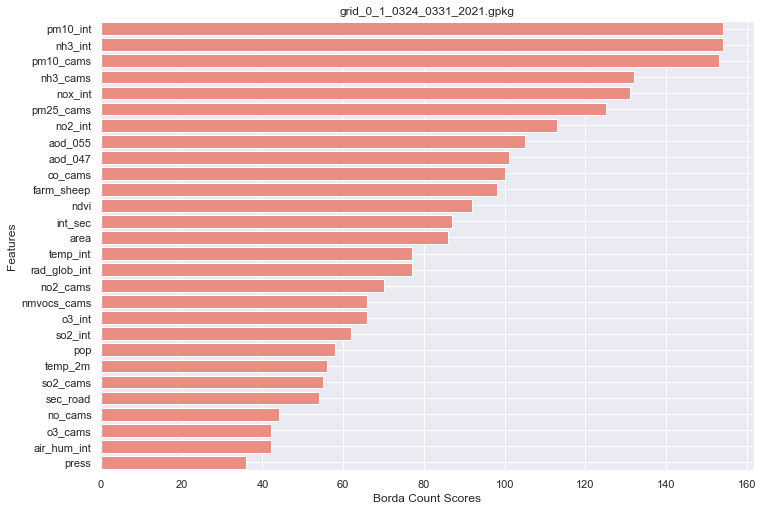

<Figure size 842.4x595.44 with 0 Axes>

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt


for index, grid in enumerate(geopackages):
    print(grid)
    display(dataframes_results[grid])
    print('\n')


for grid in geopackages:
    dataframes_results[grid].to_csv(r'assets/Votes/'+RESOLUTION+grid[:-5]+'.csv', index = False)


general_fs = pd.DataFrame()
general_fs['Features'] = list(dataframes_results.values())[0]['Features']
for index, grid in enumerate(geopackages):

    dataframes_results[grid].sort_values(by ='Borda Count Voting', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
    labels_selected = pd.DataFrame()
    labels_selected['Features'] = dataframes_results[grid]['Features']
    labels_selected['Borda Count Voting'] = dataframes_results[grid]['Borda Count Voting'].round(decimals = 3)

    labels_selected.to_csv(r'assets/features_'+RESOLUTION+'/'+grid[:-5]+'.csv', index = False)
    labels_selected.to_excel('assets/features_'+RESOLUTION+'/'+grid[:-5]+'.xlsx')
    general_fs[index] = dataframes_results[grid]['Borda Count Voting']


general_fs['Scores'] = m.borda_voting(general_fs)
general_fs.to_csv(r'assets/features_'+RESOLUTION+'general'+'.csv', index = False)

sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})


for grid in geopackages:
    
    res = pd.read_csv('assets/features_'+RESOLUTION+'/'+grid[:-5]+'.csv')
    res = res.sort_values(by=['Borda Count Voting'], ascending = False)
    print(grid)
    print(res)
    f = plt.figure()
    sns.barplot(
    y='Features', 
    x='Borda Count Voting', 
    color='salmon', 
    data=res
)

    
    plt.xticks(rotation=0)
    plt.ylabel("Features")
    plt.xlabel("Borda Count Scores")
    plt.title(grid)
    plt.gca().yaxis.grid(linestyle='-')
    fig = f.get_figure()
    fig.savefig('tests/'+grid[:-5]+'.png', bbox_inches='tight')
    plt.show()

    plt.clf()






## Other methods
In this sections are grouped method which are not included in the previous feature selection results. These methods are:
* Exhaustive feature selection;
* Recursive feature selection;
* Multiscale Geographically Weighted Regression (MGWR);



### MGWR bandwidth and Betas computation
bandwidths = []

for index in range(0,len(dataframes_results)):
    X = grid_data[index].loc[:, grid_data[index].columns != target_variable.value]
    coords = list(zip(X['lat_cen'], X['lng_cen']))
    X.pop('lat_cen')
    X.pop('lng_cen')
    Y = grid_data[index][target_variable.value]
    
    

    res = m.mgwr_beta(grid_data[index], target_variable.value, 50, geopackages[index])
    list(dataframes_results.values())[index]['MGWR Median Betas'] = m.NormalizeData(res['Betas Median'])
    bandwidths.append(res['Bandwidthds'])
    
    x = list(dataframes_results.values())[index].loc[:, list(dataframes_results.values())[index].columns != 'Features'].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    temp = pd.DataFrame(x_scaled)
    mean_results = temp.mean(axis=1)
    list(dataframes_results.values())[index]['Average Scores'] = mean_results

# MGWR Bandwidths bar plots
m.show_bars(labels_list, bandwidths, 'MGWR Bandwidths', geopackages)

res = []
for grid in geopackages:
        temp = (dataframes_results[grid])['MGWR Median Betas']
        temp = m.NormalizeData1D(temp)
        res.append(temp)

# MGWR Median(Betas) bar plots
m.show_bars(labels_list, res, 'MGWR Median Betas', geopackages)


res = []
for grid in geopackages:
        temp = (dataframes_results[grid])['Average Scores']
        res.append(temp)

# Average scores bar plots (including mgwr results)
m.show_bars(labels_list, res, 'Average Scores', geopackages)

### Exhaustive feature selection


In [ ]:
efs_results = []
for index in range(0,len(dataframes_results)):
    X = grid_data[index].loc[:, grid_data[index].columns != target_variable.value]
    coords = list(zip(X['lat_cen'], X['lng_cen']))
    X.pop('lat_cen')
    X.pop('lng_cen')
    Y = grid_data[index][target_variable.value]
    efs_results.append(m.exhaustive_feature_selection(X, Y))

### Recursive feature selection


In [13]:
rfe_results = []
for index in range(0,len(dataframes_results)):
    X = grid_data[index].loc[:, grid_data[index].columns != target_variable.value]
    coords = list(zip(X['lat_cen'], X['lng_cen']))
    X.pop('lat_cen')
    X.pop('lng_cen')
    Y = grid_data[index][target_variable.value]
    m.recursive_feature_selection(X, Y.astype(int), 20)
    
for index, grid in enumerate(geopackages):
    rfe_results[index].sort_values(by =['Ranking'], axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    rfe_results[index].to_csv(r'RFS'+grid[:-5]+'.csv', index = False)
    


IndexError: list index out of range

In [8]:
rfe_results

[          Features  isSelected  Ranking
 47      farm_sheep        True        1
 65        no2_cams        True        1
 73          o3_int        True        1
 74        pm10_int        True        1
 60         no_cams        True        1
 ..             ...         ...      ...
 2             dsf3       False       59
 81  wind_speed_int       False       60
 1             dsf2       False       61
 41         highway       False       62
 0         dusafSum       False       63
 
 [82 rows x 3 columns],
         Features  isSelected  Ranking
 79  rad_glob_int        True        1
 72       no2_int        True        1
 70        co_int        True        1
 63     dust_cams        True        1
 59        o3_s5p        True        1
 ..           ...         ...      ...
 43      sec_road       False       60
 1           dsf2       False       61
 0       dusafSum       False       62
 40       int_sec       False       63
 41       highway       False       64
 
 [83 rows x 